In [1]:
import cmd
import pandas as pd
import warnings

from src.analysis_utils import calculate_centrality, create_centrality_graph, create_crosstable_heatmap, plot_frequency_map
from src.populate_db import connect_to_database

warnings.filterwarnings('ignore')


# Exploring Metal Genres

This notebook will answer some basic questions about the metal genres in the database:
- What are the genres present in the data?
- How different genres relate to each other?
- Which genres were more active across time?
- Which genres are more present in different countries?

Let's query the database and load the data into a dataframe.

In [2]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
               SELECT band.name, band.country, genre.genre_name, YEAR(band.start_date) - MOD(YEAR(band.start_date), 10) AS start_decade
               FROM band 
               INNER JOIN band_genre ON band.id = band_genre.band_id 
               INNER JOIN genre ON band_genre.genre_id = genre.id;
               """)
result = cursor.fetchall()

In [3]:
df = pd.DataFrame(result, columns=['Band', 'Country', 'Genre', 'Decade'])
df = df.dropna()
df.Decade = df.Decade.astype(int)

## What are the genres present in the data?

There are 136 unique genres in the data, which is a lot! Below we have a list of the 38 genres that are associated with at least 20 bands.

There are a few points that need to be taken into account about the data:
* The data is the result of:
    1. querying music genres containing the word "metal" in the label;
    2. looking for bands belonging to those metal genres;
    3. listing all the genres associated with the found bands; and
    4. filtering only the genres containing the words: "rock", "grindcore", "death", "doom", "gothic", "metal", and "djent", as the complete results were too broad.
    
    This means that not all genres are metal subgenres, but they were included to ensure enough diversity in the data.
* The attribution of a band to a particular genre is not consistent across bands, with differences of granularity in classifications (some band classifications are very specific, while others are only attributed to broader genres.)
* This granularity variation must be taken into account when interpreting the results, as although all are considered to be at the same level in the analysis, the genres actually follow a hierarchy ("thrash metal", "black metal", and "death metal" are at the same level, but "symphonic black metal" can be considered a subgenre of "black metal".)

In [4]:
cli = cmd.Cmd()

print(f"Number of unique Genres: {len(df.Genre.unique())}")
low_freq_Genres = list(df['Genre'].value_counts().loc[df['Genre'].value_counts() < 20].keys())
filtered_df = df[~df['Genre'].isin(low_freq_Genres)]
print(f"Number of unique Genres associated with at least 20 bands: {len(filtered_df.Genre.unique())}")
Genres = sorted([Genre.capitalize() for Genre in filtered_df.Genre.unique().tolist()])
print("\nList of Genres:")
print(cli.columnize(Genres, displaywidth=50))

Number of unique Genres: 136
Number of unique Genres associated with at least 20 bands: 38

List of Genres:
Alternative metal    Pagan metal            
Alternative rock     Pop rock               
Avant-garde metal    Post-metal             
Black metal          Power metal            
Brutal death metal   Progressive metal      
Christian metal      Progressive rock       
Death metal          Punk rock              
Doom metal           Rap metal              
Folk metal           Rock music             
Funk metal           Sludge metal           
Glam metal           Speed metal            
Gothic metal         Stoner metal           
Groove metal         Stoner rock            
Hard rock            Symphonic black metal  
Heavy metal          Symphonic metal        
Industrial metal     Technical death metal  
Melodic death metal  Thrash metal           
Metalcore            Traditional heavy metal
Nu metal             Viking metal           
None


## How different genres relate to each other?

To answer that question, let's plot a graph representing the degree centrality of genres. 

Degree centrality is a measure of the direct connections of a node in a network, so nodes with higher degree centrality are connected to more nodes in the network. In our case, that means that a high centrality genre is often classified along with other genres in the same band. These genres are represented in a more central position and in a lighter color in the graph.

Not surprisingly, heavy metal is the most central genre, as it can be considered a broad, overarching category in metal. Other central genres are thrash and death metal, along with hard rock, while technical and brutal death metal, pagan and viking metal, and symphonic black metal are peripheral in the graph.

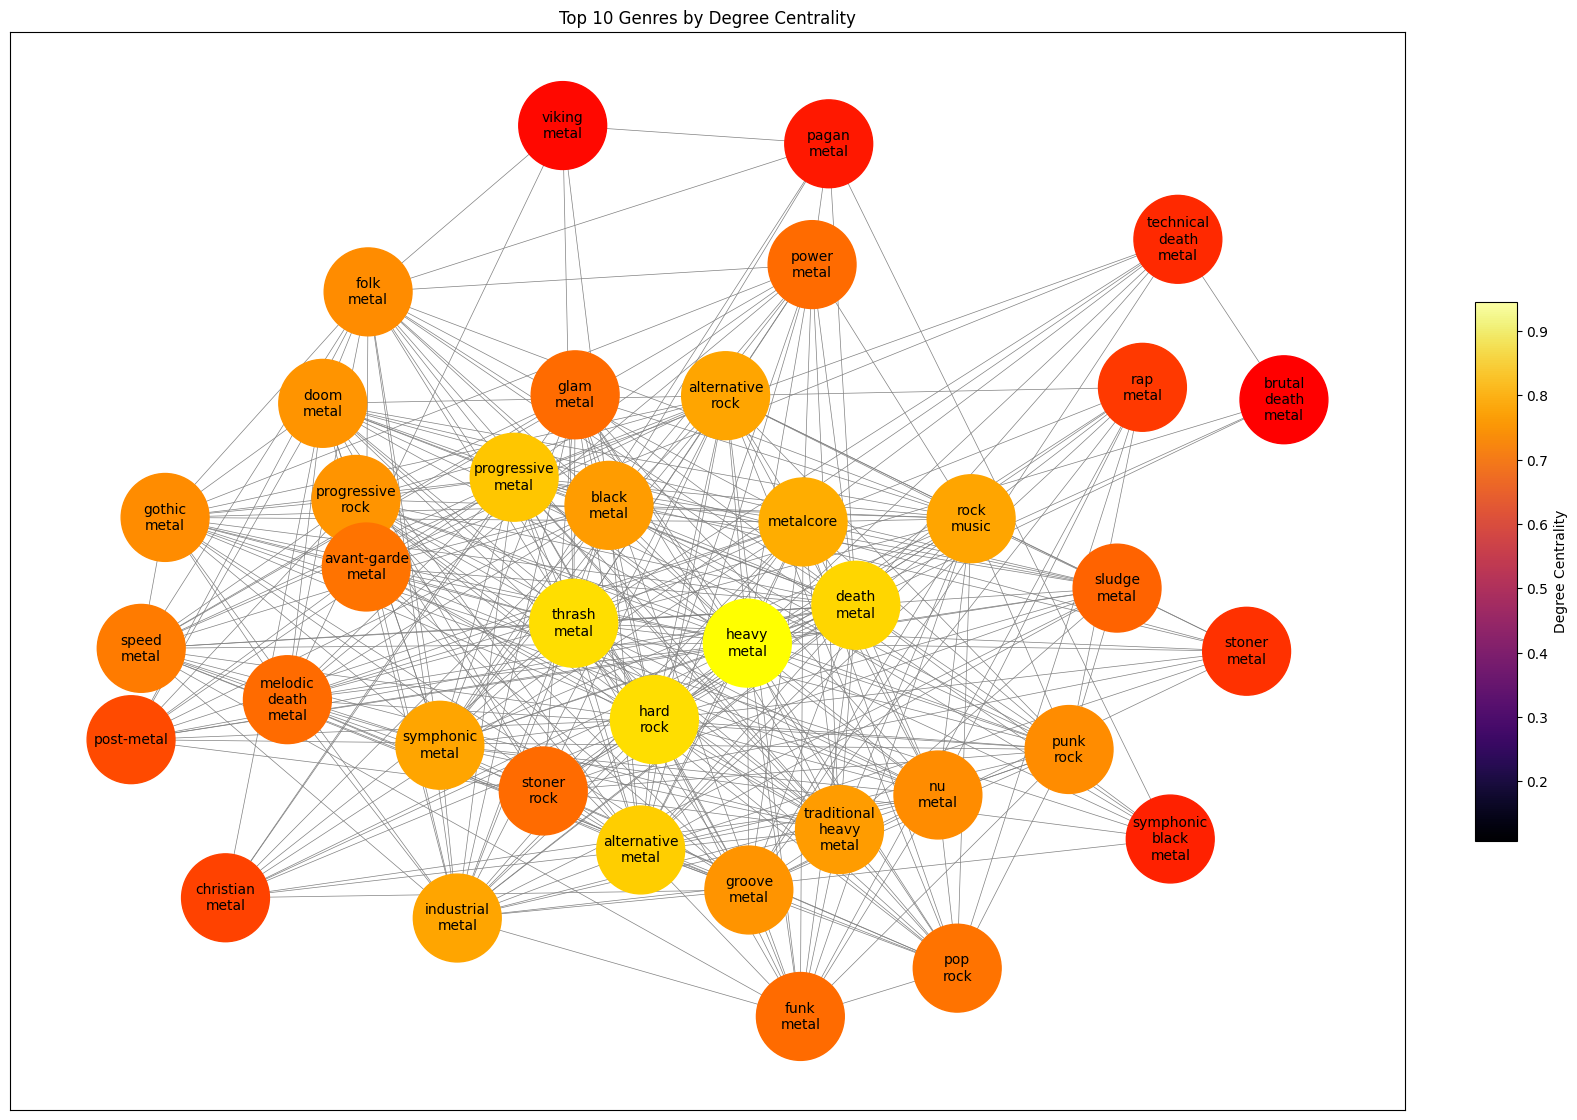

In [5]:
G, centrality_measures = calculate_centrality(filtered_df, 'Band', 'Genre')
create_centrality_graph(G, centrality_measures['Degree Centrality'], 'Degree Centrality')

## Which genres were more active across time?

The heatmap below shows the number of new bands in each decade, grouped by genre.

From the 60's to 70's, we can see the ascension of heavy metal. Thrash metal dominates the 80's although many heavy metal bands were also born in this decade. Interestingly, the 90's saw a surge in the number of black metal bands, with more new bands than any other genre in any other decade.  This decade also saw the inception of several death metal, progressive metal, thrash metal, and alternative metal bands. The number of new bands declined overall since the 00's, while the dominant genres have largely remained consistent with the preceding decade.

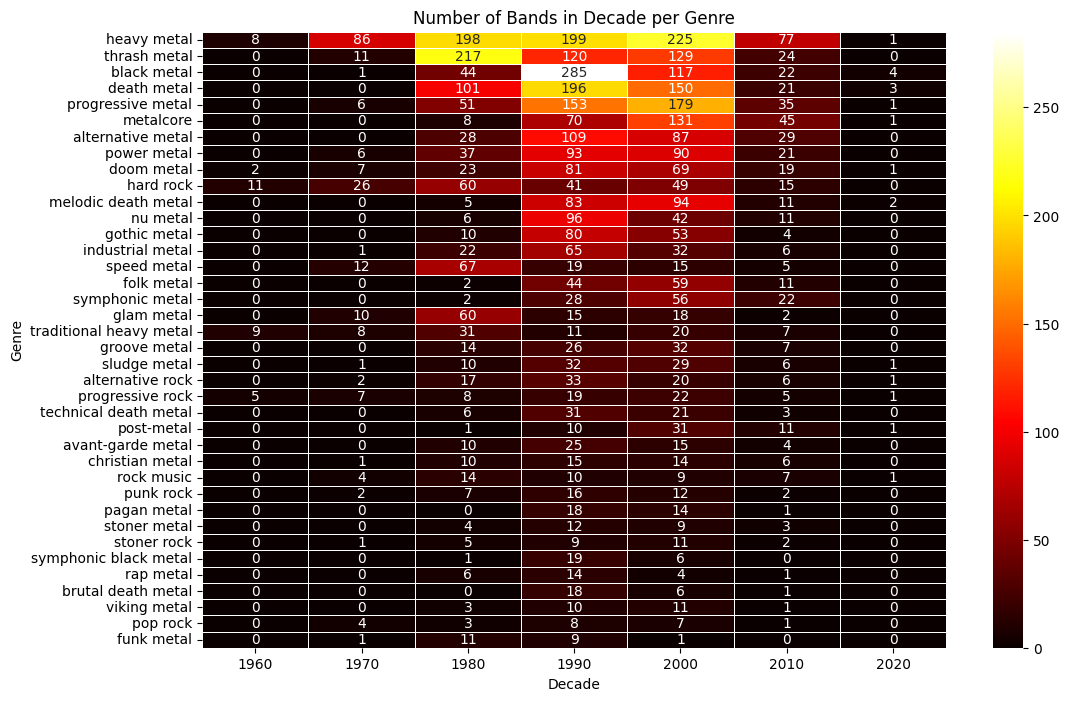

In [17]:
cross_genre_decade = create_crosstable_heatmap(filtered_df, 'Genre', 'Decade', n_x=38)

## Which genres are more present in different countries?

The following heatmap shows the number of bands in each genre per country. As expected, the United States has the larger number of bands in almost all genres, as it is very large country. 

However, a few notable exceptions are black metal, with the most bands originated in Norway; melodic death metal, with bands from Sweden; power metal, from Sweden and Germany; and gothic metal, also from Germany.

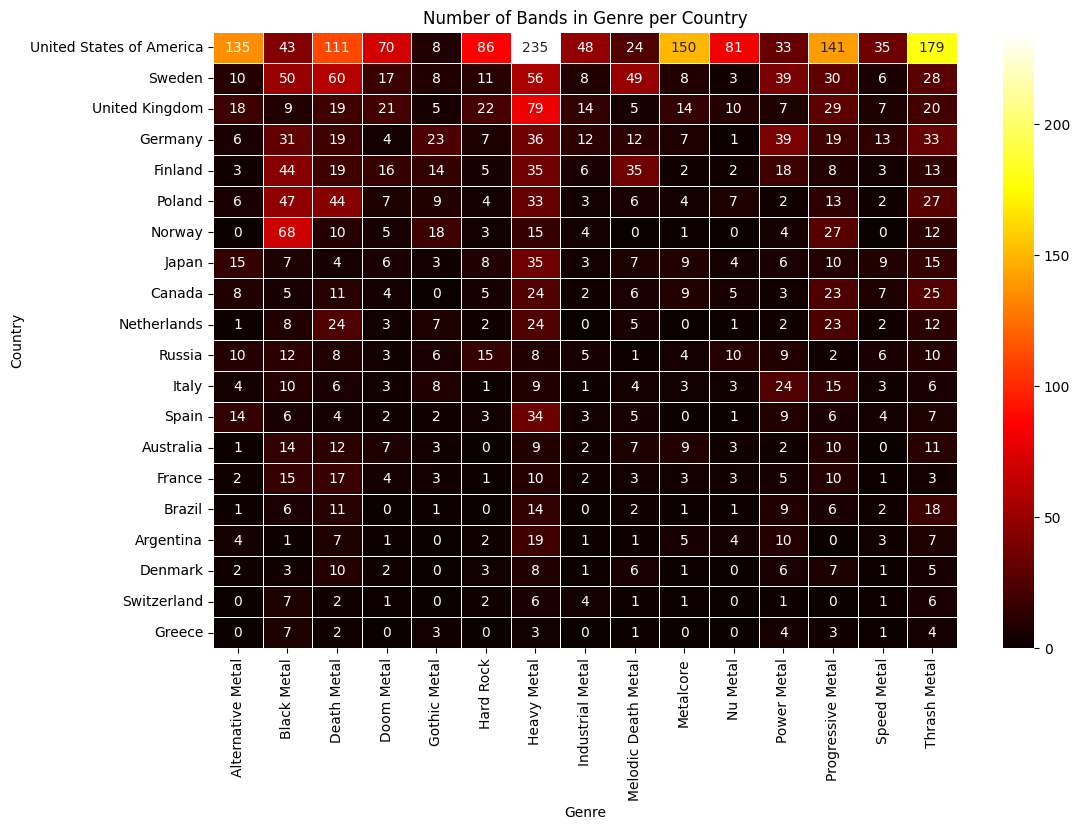

In [7]:
cross_country_genre = create_crosstable_heatmap(df, 'Country', 'Genre', 20, 15)

Finally, we can see which genre is the most frequent in each country, considering the bands' country of origin.

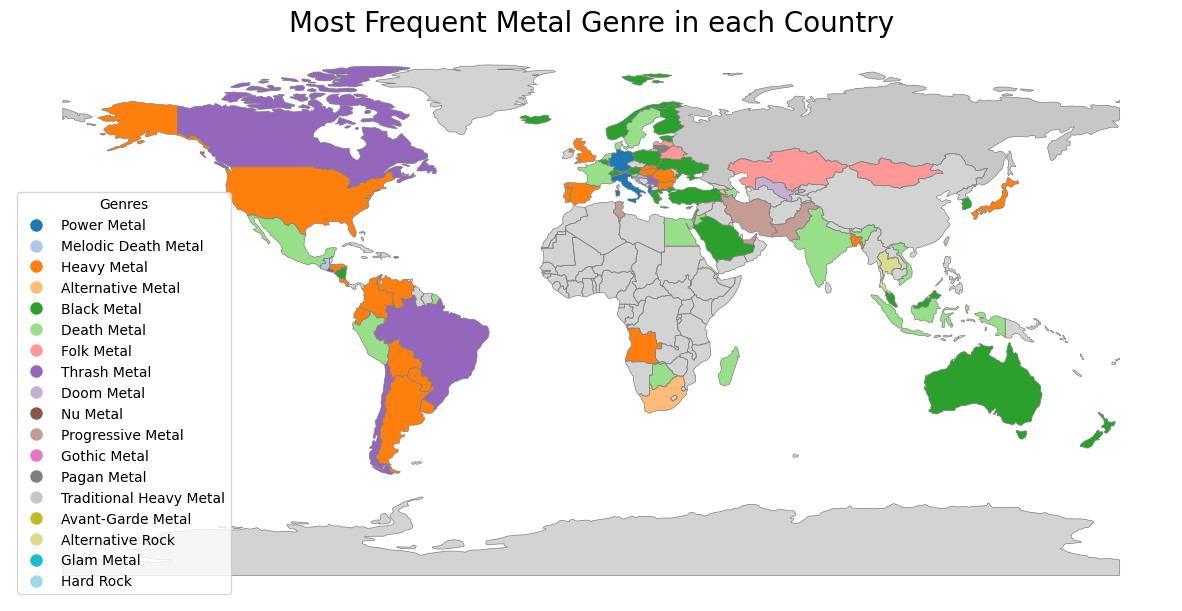

In [5]:
plot_frequency_map(filtered_df)